In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import json
import math
import os
from tensorflow import keras
import cv2
from PIL import Image
import numpy as np
from keras import layers
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg16 import VGG16
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D,BatchNormalization
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.applications.xception import Xception
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
# from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers.legacy import Adam
from keras.models import Model
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools


%matplotlib inline

In [ ]:
# import os

# def remove_images(directory, number_to_remove):
#     images = os.listdir(directory)
#     images = [image for image in images if image.endswith('.jpg') or image.endswith('.jpeg')]  # Filter for specific image formats

#     if number_to_remove > len(images):
#         print("Number of images to remove exceeds the total number of images.")
#         return

#     images_to_remove = images[:number_to_remove]  # Select the first 'number_to_remove' images

#     for image in images_to_remove:
#         os.remove(os.path.join(directory, image))
#         print(f"Removed: {image}")

# # Example usage
# directory_path = '/content/drive/MyDrive/research/kidney/Normal'
# number_of_images_to_remove = 3500

# remove_images(directory_path, number_of_images_to_remove)

In [ ]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".jpg" or ftype == ".jpeg":
            img = read(PATH)

            img = cv2.resize(img, (RESIZE,RESIZE))

            IMG.append(np.array(img))
    return IMG

In [ ]:
# import os
# import cv2
# import numpy as np
# from PIL import Image
# from tqdm import tqdm
# import matplotlib.pyplot as plt

# def Dataset_loader(DIR, RESIZE, sigmaX=10):
#     IMG = []
#     # read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
#     count = 0  # Counter to track rows

#     for IMAGE_NAME in tqdm(os.listdir(DIR)):
#         PATH = os.path.join(DIR, IMAGE_NAME)
#         _, ftype = os.path.splitext(PATH)
#         if ftype == ".jpg" or ftype == ".jpeg":
#             img = cv2.imread(PATH)

#             img = cv2.resize(img, (RESIZE, RESIZE))

#             # Convert the image to grayscale
#             gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

#             # Apply Gaussian Blur to smooth the image
#             blurred_img = cv2.GaussianBlur(gray_img, (5, 5), 0)

#             # Apply Thresholding to create a binary image
#             _, thresh_img = cv2.threshold(blurred_img, 100, 255, cv2.THRESH_BINARY)

#             # Expand dimensions to convert single-channel to three channels
#             expanded_img = np.expand_dims(thresh_img, axis=2)
#             expanded_img = np.concatenate([expanded_img] * 3, axis=2)

#             IMG.append(expanded_img)  # Append the processed image

#     return IMG


In [ ]:
cyst = np.array(Dataset_loader('/content/drive/MyDrive/kidney/Cyst',224))
stone = np.array(Dataset_loader('/content/drive/MyDrive/kidney/Normal',224))
tumor = np.array(Dataset_loader('/content/drive/MyDrive/kidney/Stone',224))
normal = np.array(Dataset_loader('/content/drive/MyDrive/kidney/Tumor',224))

100%|██████████| 1583/1583 [00:26<00:00, 59.48it/s] 


In [ ]:
print(len(cyst))
cyst.shape

1509


(1509, 224, 224, 3)

In [ ]:
# Create labels
cyst_label = np.zeros(len(cyst))
stone_label = np.ones(len(stone))
tumor_label = np.full(len(tumor), 2)  # Use np.full to fill with 2
normal_label = np.full(len(normal), 3)

In [ ]:
# Merge data
X_train = np.concatenate((cyst, stone, tumor, normal), axis = 0)
Y_train = np.concatenate((cyst_label, stone_label, tumor_label, normal_label), axis = 0)

In [ ]:
# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

In [ ]:
# To categorical
Y_train = to_categorical(Y_train, num_classes= 4)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train,
    test_size=0.2,
    random_state=11
)

In [ ]:
print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(4836, 224, 224, 3)
(1210, 224, 224, 3)
(4836, 4)
(1210, 4)


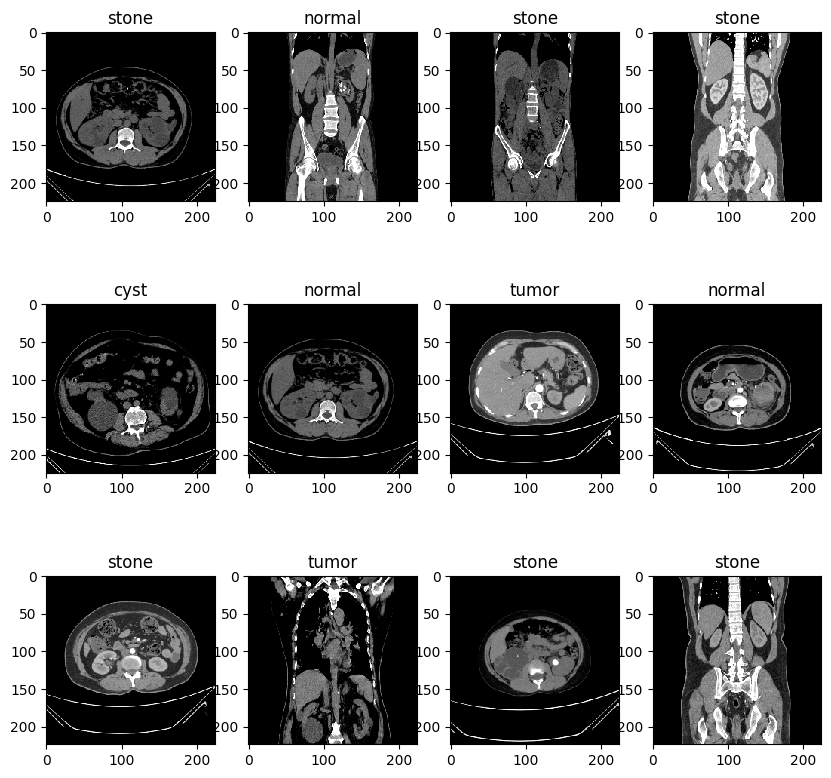

In [ ]:
# # Display first 15 images of moles, and how they are classified
# # Here IDC (+) means Benign
# # IDC (-) means Malignant
w=60
h=40
fig=plt.figure(figsize=(10, 10))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('cyst')
    elif np.argmax(Y_train[i]) == 1:
        ax.title.set_text('stone')
    elif np.argmax(Y_train[i]) == 2:
        ax.title.set_text('tumor')
    else:
        ax.title.set_text('normal')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

In [ ]:
BATCH_SIZE = 32

# Using original generator
train_generator = ImageDataGenerator(
        # zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        shear_range = 0.5,
        width_shift_range=0.4,
        height_shift_range=0.4,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True  # randomly flip images
    )

In [ ]:
IMAGE_SIZE=224
# Model
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
inputs = Input(input_shape)

xception   = Xception(weights='imagenet', include_top=False, input_shape=input_shape)(inputs)
densesnet      = DenseNet201(weights='imagenet', include_top=False, input_shape=input_shape)(inputs)
inception_resNnt      = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=input_shape)(inputs)
inception      = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)(inputs)
resnet      = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)(inputs)
mobilenet      = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)(inputs)
nasnet_mobile      = NASNetMobile(weights='imagenet', include_top=False, input_shape=input_shape)(inputs)
vgg19      = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)(inputs)
vgg16      = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)(inputs)

In [ ]:
outputs = GlobalAveragePooling2D()(inception_resNnt)
# Concatenate(axis=-1)([GlobalAveragePooling2D()(vgg), GlobalAveragePooling2D()(nas)])
# outputs = Dropout(0.4)(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(32,activation='relu')(outputs)
# outputs = Dropout(0.2)(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(4, activation='softmax')(outputs)

model = Model(inputs, outputs)
model.compile(optimizer=Adam(lr=0.0001, decay=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 inception_resnet_v2 (Funct  (None, 5, 5, 1536)        54336736  
 ional)                                                          
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization_301 (B  (None, 1536)              6144      
 atchNormalization)                                              
                                                                 
 dense (Dense)               (None, 32)                49184     
                                                             

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="/content/drive/My Driveweights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [ ]:
history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=3,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

<ipython-input-20-c2079e616d10>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/3
152/151 [==============================] - ETA: 0s - loss: 0.6568 - accuracy: 0.7384

151/151 [==============================] - 158s 792ms/step - loss: 0.6568 - accuracy: 0.7384 - val_loss: 0.2504 - val_accuracy: 0.9355 - lr: 1.0000e-04
Epoch 2/3
152/151 [==============================] - ETA: 0s - loss: 0.2166 - accuracy: 0.9233

151/151 [==============================] - 114s 754ms/step - loss: 0.2166 - accuracy: 0.9233 - val_loss: 0.1103 - val_accuracy: 0.9760 - lr: 1.0000e-04
Epoch 3/3
152/151 [==============================] - ETA: 0s - loss: 0.1405 - accuracy: 0.9539

151/151 [==============================] - 113s 741ms/step - loss: 0.1405 - accuracy: 0.9539 - val_loss: 0.1524 - val_accuracy: 0.9479 - lr: 1.0000e-04


38/38 [==============================] - 6s 167ms/step
Confusion matrix, without normalization
[[300   0   2   0]
 [  4 317   1   6]
 [ 44   0 233   1]
 [  2   3   0 297]]


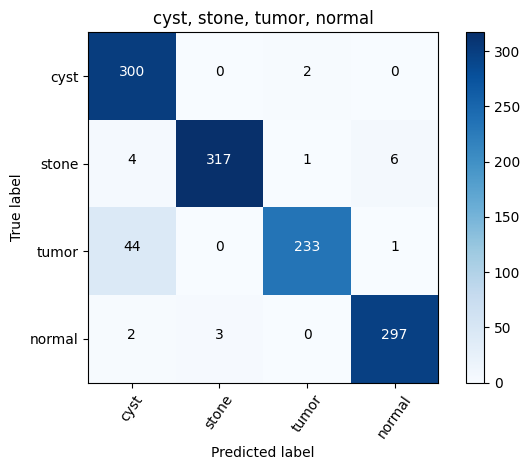

In [ ]:
Y_pred = model.predict(x_val)
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(y_val, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['cyst', 'stone', 'tumor', 'normal']
plot_confusion_matrix(cm, cm_plot_label, title ='cyst, stone, tumor, normal')

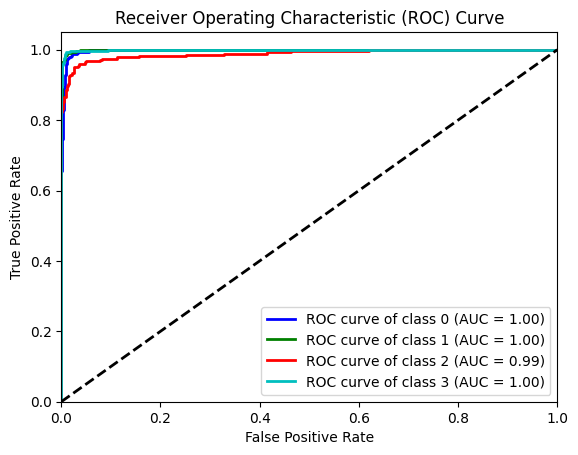

In [ ]:
# from sklearn.metrics import roc_auc_score, auc
# from sklearn.metrics import roc_curve
# # roc_log = roc_auc_score(np.argmax(y_val, axis=1), np.argmax(Y_pred, axis=1), multi_class='ovo')
# false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(y_val, axis=1), np.argmax(Y_pred, axis=1))
# area_under_curve = auc(false_positive_rate, true_positive_rate)

# plt.plot([0, 1], [0, 1], 'r--')
# plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve')
# plt.legend(loc='best')
# plt.show()
# #plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
# plt.close()

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Assuming y_val and Y_pred are one-hot encoded
y_pred_classes = np.argmax(Y_pred, axis=1)
y_val_classes = np.argmax(y_val, axis=1)

# Compute ROC curve and ROC area for each class
n_classes = 4
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_classes == i, Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure()
colors = ['b', 'g', 'r', 'c']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (AUC = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


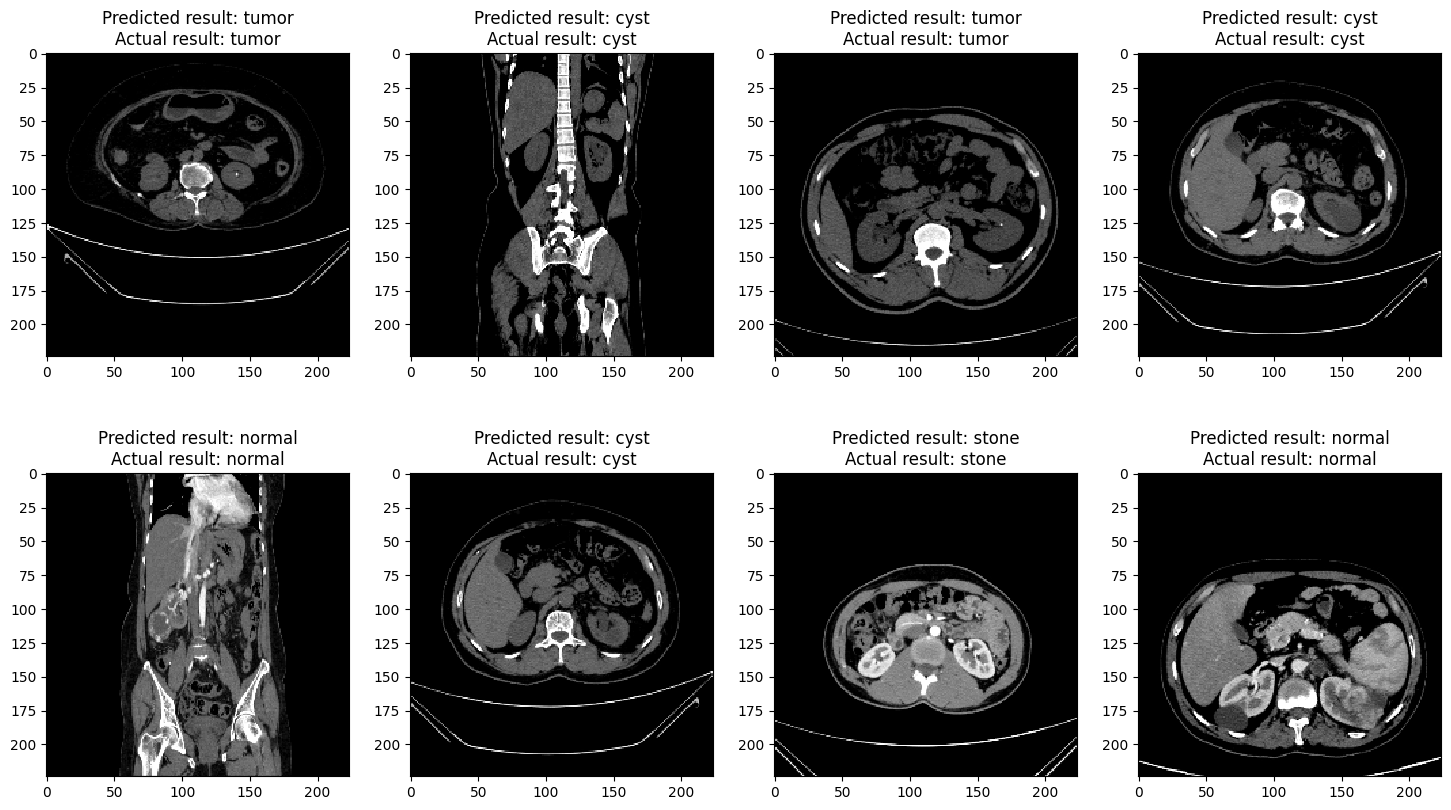

In [ ]:

i=0
prop_class=[]
mis_class=[]

for i in range(len(y_val)):
    if(np.argmax(y_val[i])==np.argmax(Y_pred[i])):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_val)):
    if(not np.argmax(y_val[i])==np.argmax(Y_pred[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

# # Display first 8 images of benign
w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==0:
        return "cyst"
    elif namecode==1:
        return "stone"
    elif namecode==2:
        return "tumor"
    else:
        return "normal"

for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result: "+ Transfername(np.argmax(Y_pred[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(y_val[prop_class[i]])))
    plt.imshow(x_val[prop_class[i]], interpolation='nearest')
plt.show()


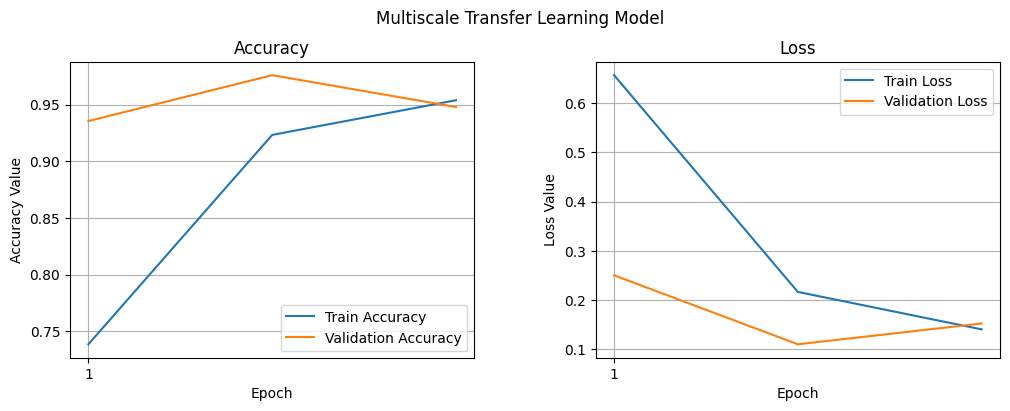

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Multiscale Transfer Learning Model', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,4))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.grid()
ax1.set_xticks(np.arange(1, 4, 4))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.grid()
ax2.set_xticks(np.arange(1, 4, 4))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

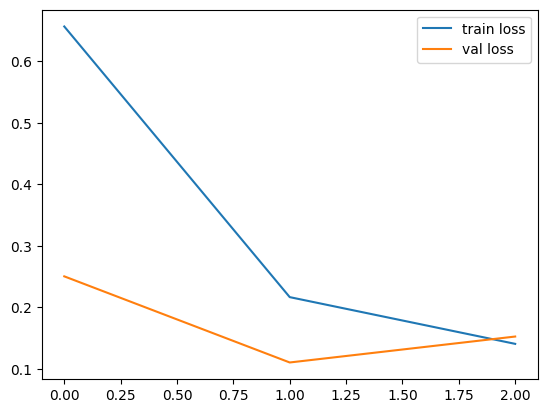

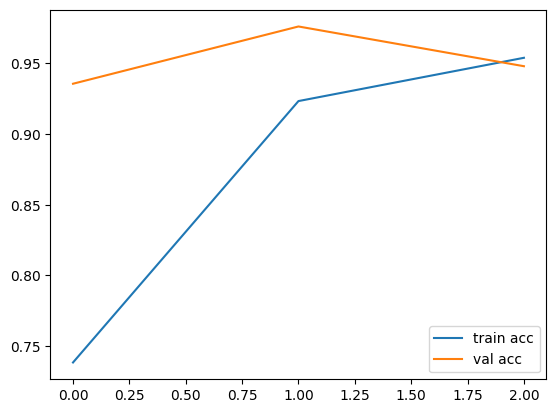

In [ ]:
# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [ ]:
pred=model.predict(x_val)
Y_pred = np.argmax(pred, 1)
y_test=np.argmax(y_val,1)

38/38 [==============================] - 6s 166ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print('Classification Report')
target_names = ['cyst', 'stone', 'tumor', 'normal']
print(classification_report(y_test, Y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

        cyst       0.86      0.99      0.92       302
       stone       0.99      0.97      0.98       328
       tumor       0.99      0.84      0.91       278
      normal       0.98      0.98      0.98       302

    accuracy                           0.95      1210
   macro avg       0.95      0.95      0.95      1210
weighted avg       0.95      0.95      0.95      1210



In [ ]:
# def preprocess_input_image(image_path):
#     img = np.asarray(Image.open(image_path).convert("RGB"))
#     img = cv2.resize(img, (224, 224))
#     img = np.array(img)
#     return img

#input_image = np.array(preprocess_input_image('/content/drive/My Drive/research/skin_cancer/test/benign/1.jpg'))
# input_image = np.array(preprocess_input_image('/content/drive/My Drive/research/knee_eye_test/knee_data/test/osteoarthritis/9062645R.png'))

# input_image_reshape = input_image.reshape(1, 224, 224, 3)

# pred=model.predict(input_image_reshape)
# input_pred = np.argmax(pred, 1)

# if input_pred[0] == 0:
#   plt.title('Not Melanoma')
# else:
#   plt.title('Melanoma')

# plt.imshow(input_image)
# plt.show()

In [ ]:
# from google.colab import files
# #Train and save your model
# model = model
# model.save('/content/drive/My Drive/research/skin_cancer/skin_cancer_xcep_94.h5')

# files.download('/content/drive/My Drive/research/skin_cancer/skin_cancer_inres_res_xcep.h5')